# Data Processing Using Dask

##  Loading Data from MongoDB using Dask

In [15]:
from pymongo import MongoClient
import pandas as pd
import dask.dataframe as dd

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["GlobalTerrorism"]
collection = db["GTD"]

# Load data from MongoDB into a Pandas DataFrame
data = list(collection.find({}, {"_id": 0}))  # Exclude MongoDB's default `_id` column
df = pd.DataFrame(data)

# Convert Pandas DataFrame to Dask DataFrame
ddf = dd.from_pandas(df, npartitions=4)

# Display schema
print(ddf.dtypes)

# Show first few rows
print(ddf.head())

eventid                 int64
iyear                   int64
imonth                  int64
iday                    int64
approxdate    string[pyarrow]
                   ...       
INT_LOG                 int64
INT_IDEO                int64
INT_MISC                int64
INT_ANY                 int64
related       string[pyarrow]
Length: 135, dtype: object
        eventid  iyear  imonth  iday approxdate  extended resolution  country  \
0  197000000001   1970       7     2       <NA>         0       <NA>       58   
1  197000000002   1970       0     0       <NA>         0       <NA>      130   
2  197001000001   1970       1     0       <NA>         0       <NA>      160   
3  197001000002   1970       1     0       <NA>         0       <NA>       78   
4  197001000003   1970       1     0       <NA>         0       <NA>      101   

          country_txt  region  ... addnotes scite1 scite2  scite3  dbsource  \
0  Dominican Republic       2  ...     <NA>   <NA>   <NA>    <NA>      PGIS  

## Handling Missing Values

In [17]:
# Check missing values
missing_counts = ddf.isnull().sum().compute()
print(missing_counts)

# Fill missing values with appropriate defaults
ddf = ddf.fillna({
    "weaptype1_txt": "Unknown",
    "targtype1_txt": "Unknown",
    "nkill": 0,
    "nwound": 0
})

eventid            0
iyear              0
imonth             0
iday               0
approxdate    201593
               ...  
INT_LOG            0
INT_IDEO           0
INT_MISC           0
INT_ANY            0
related       183096
Length: 135, dtype: int64


In [19]:
# Identify columns with more than 10,000 missing values
columns_to_drop = missing_counts[missing_counts > 10000].index.tolist()
print(f"Columns to drop: {columns_to_drop}")

# Drop the identified columns
ddf = ddf.drop(columns=columns_to_drop)

# Verify the changes
print(ddf.head())

Columns to drop: ['approxdate', 'resolution', 'location', 'summary', 'alternative', 'alternative_txt', 'attacktype2', 'attacktype2_txt', 'attacktype3', 'attacktype3_txt', 'targsubtype1', 'targsubtype1_txt', 'corp1', 'targtype2', 'targtype2_txt', 'targsubtype2', 'targsubtype2_txt', 'corp2', 'target2', 'natlty2', 'natlty2_txt', 'targtype3', 'targtype3_txt', 'targsubtype3', 'targsubtype3_txt', 'corp3', 'target3', 'natlty3', 'natlty3_txt', 'gsubname', 'gname2', 'gsubname2', 'gname3', 'gsubname3', 'motive', 'guncertain2', 'guncertain3', 'nperps', 'nperpcap', 'claimed', 'claimmode', 'claimmode_txt', 'claim2', 'claimmode2', 'claimmode2_txt', 'claim3', 'claimmode3', 'claimmode3_txt', 'compclaim', 'weapsubtype1', 'weapsubtype1_txt', 'weaptype2', 'weaptype2_txt', 'weapsubtype2', 'weapsubtype2_txt', 'weaptype3', 'weaptype3_txt', 'weapsubtype3', 'weapsubtype3_txt', 'weaptype4', 'weaptype4_txt', 'weapsubtype4', 'weapsubtype4_txt', 'weapdetail', 'nkill', 'nkillus', 'nkillter', 'nwound', 'nwoundus', 

# Exploratary Data Analysis (EDA)

## Filtering Data for Analysis

In [21]:
# Filter dataset to include only incidents after 1990
filtered_ddf = ddf[ddf['iyear'] >= 1990]

# Persist the filtered data
filtered_ddf = filtered_ddf.persist()
print(filtered_ddf.head())

            eventid  iyear  imonth  iday  extended  country country_txt  \
41069  199001000001   1990       1     0         0      110     Lebanon   
41070  199001010001   1990       1     1         0       92       India   
41071  199001010002   1990       1     1         0       92       India   
41072  199001010003   1990       1     1         0       92       India   
41073  199001010004   1990       1     1         0       26     Bolivia   

       region                  region_txt          provstate  ... individual  \
41069      10  Middle East & North Africa             Beirut  ...          0   
41070       6                  South Asia  Jammu and Kashmir  ...          0   
41071       6                  South Asia  Jammu and Kashmir  ...          0   
41072       6                  South Asia  Jammu and Kashmir  ...          0   
41073       3               South America         Cochabamba  ...          0   

       weaptype1  weaptype1_txt  property  ishostkid  dbsource  INT_

## Aggregating Data: Trend Analysis

In [23]:
# Group by year and count the number of attacks
trend_analysis = filtered_ddf.groupby("iyear").size().compute()
print(trend_analysis)

iyear
1990     3886
1991     4685
1992     5071
1994     3456
1995     3081
1996     3058
1997     3198
1998      934
1999     1396
2000     1823
2001     1912
2002     1330
2003     1280
2004     1164
2005     2017
2006     2757
2007     3250
2008     4801
2009     4723
2010     4827
2011     5075
2012     8525
2013    12047
2014    16960
2015    15138
2016    14051
2017    11364
2018     9853
2019     8537
2020     8438
2021     4960
dtype: int64


## Finding Hotspots

In [25]:
# Group by country and count the number of incidents
hotspots = filtered_ddf.groupby("country_txt").size().compute()

# Sort by descending order
hotspots = hotspots.sort_values(ascending=False)
print(hotspots.head(10))

country_txt
Iraq           28032
Afghanistan    20347
Pakistan       15441
India          12912
Philippines     7333
Yemen           6317
Nigeria         5991
Colombia        5621
Somalia         5424
Thailand        4128
dtype: int64


## Analyzing Attack Types

In [27]:
# Count occurrences of each attack type
attack_types = filtered_ddf.groupby("attacktype1_txt").size().compute()

# Sort by frequency
attack_types = attack_types.sort_values(ascending=False)
print(attack_types)

attacktype1_txt
Bombing/Explosion                      81532
Armed Assault                          41719
Assassination                          14826
Hostage Taking (Kidnapping)            12839
Unknown                                10275
Facility/Infrastructure Attack          9949
Unarmed Assault                         1188
Hostage Taking (Barricade Incident)      669
Hijacking                                600
dtype: int64


## Saving Processed Data

In [36]:
# Save as Parquet format for efficiency
filtered_ddf.to_parquet("filtered_GTD.parquet", write_index=False)

# Data Visualizations

## Trend Analysis: Number of Terrorist Attacks Over Time

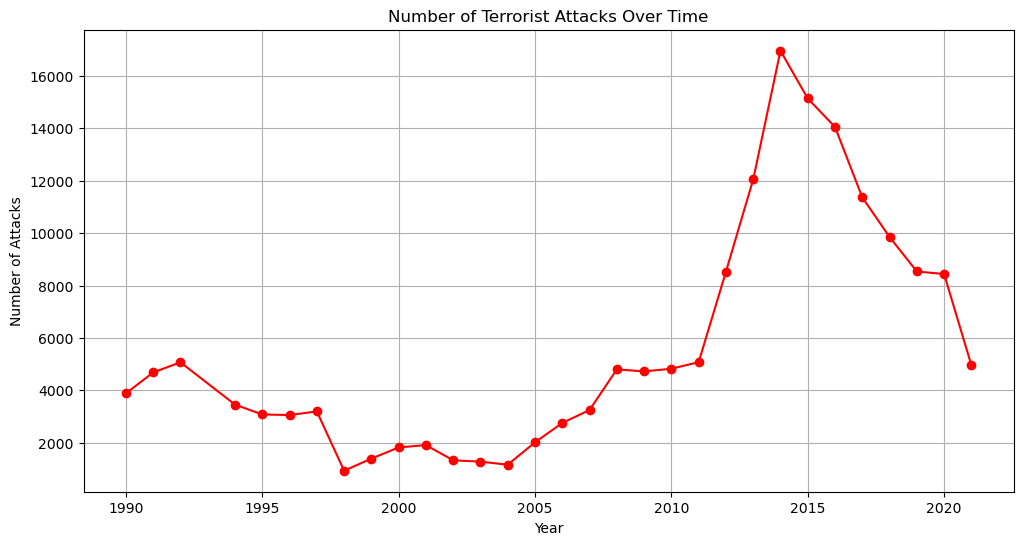

In [42]:
import dask.dataframe as dd
import matplotlib.pyplot as plt

# Convert 'iyear' to numeric
ddf['iyear'] = filtered_ddf['iyear'].astype('int')

# Group by year and count attacks
attacks_per_year = filtered_ddf.groupby('iyear').size().compute()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(attacks_per_year.index, attacks_per_year.values, marker='o', linestyle='-', color='red')
plt.xlabel('Year')
plt.ylabel('Number of Attacks')
plt.title('Number of Terrorist Attacks Over Time')
plt.grid()
plt.show()

## Hotspot Detection: Top 10 Most Affected Countries

C:\Users\sithu\AppData\Local\Temp\ipykernel_48776\3453210845.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette="Reds_r")


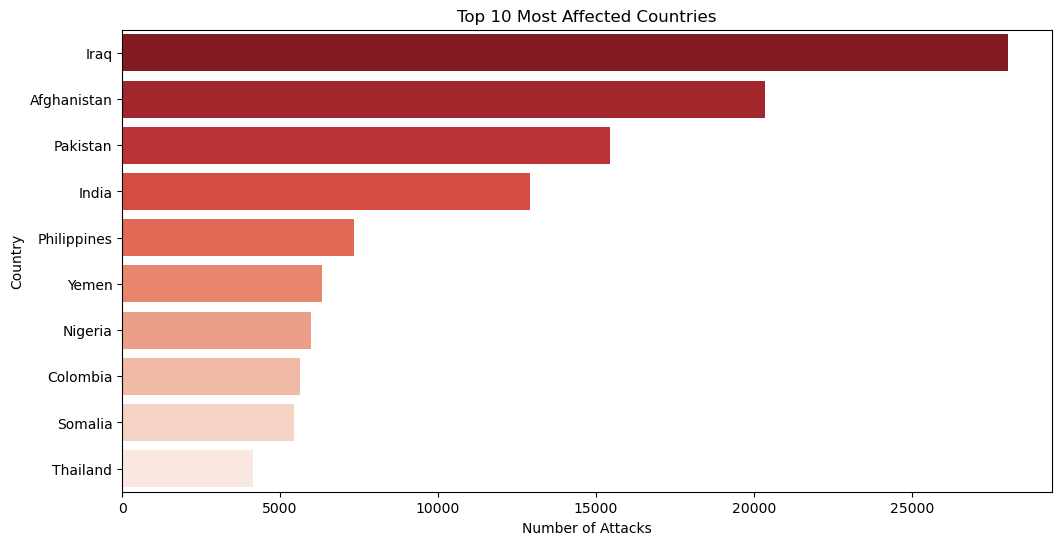

In [46]:
import seaborn as sns

# Get top 10 countries
top_countries = hotspots.nlargest(10)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette="Reds_r")
plt.xlabel('Number of Attacks')
plt.ylabel('Country')
plt.title('Top 10 Most Affected Countries')
plt.show()

## Attack Patterns: Most Common Attack Types

C:\Users\sithu\AppData\Local\Temp\ipykernel_48776\4065355495.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attack_types.values, y=attack_types.index, palette="Blues_r")


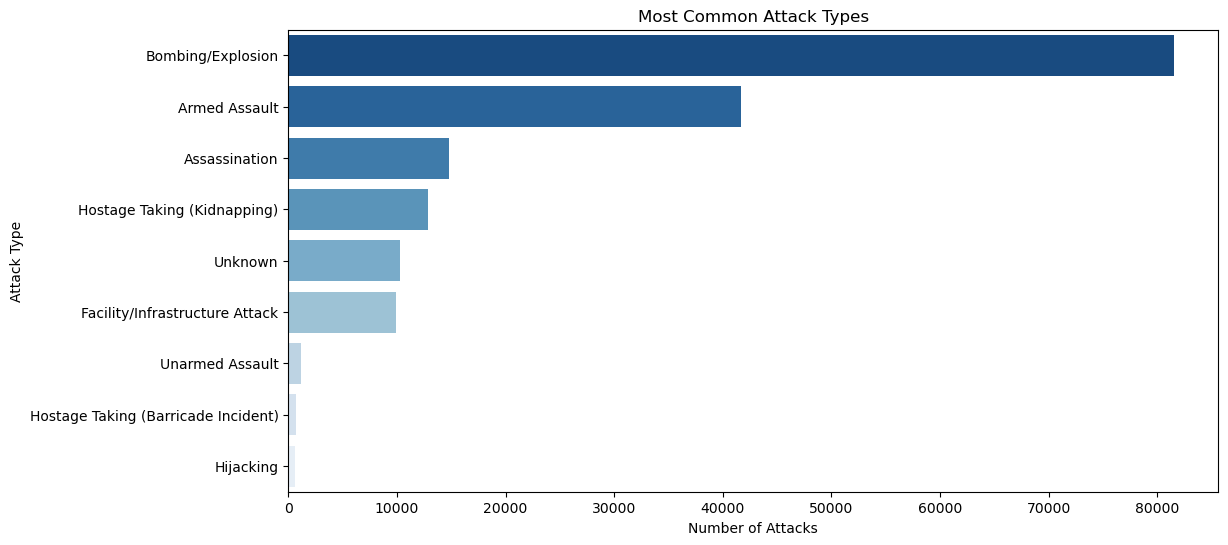

In [56]:
# Sort and plot
plt.figure(figsize=(12, 6))
sns.barplot(x=attack_types.values, y=attack_types.index, palette="Blues_r")
plt.xlabel('Number of Attacks')
plt.ylabel('Attack Type')
plt.title('Most Common Attack Types')
plt.show()

## Weapons Used in Attacks

C:\Users\sithu\AppData\Local\Temp\ipykernel_48776\339862402.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weapons_used.values, y=weapons_used.index, palette="Purples_r")


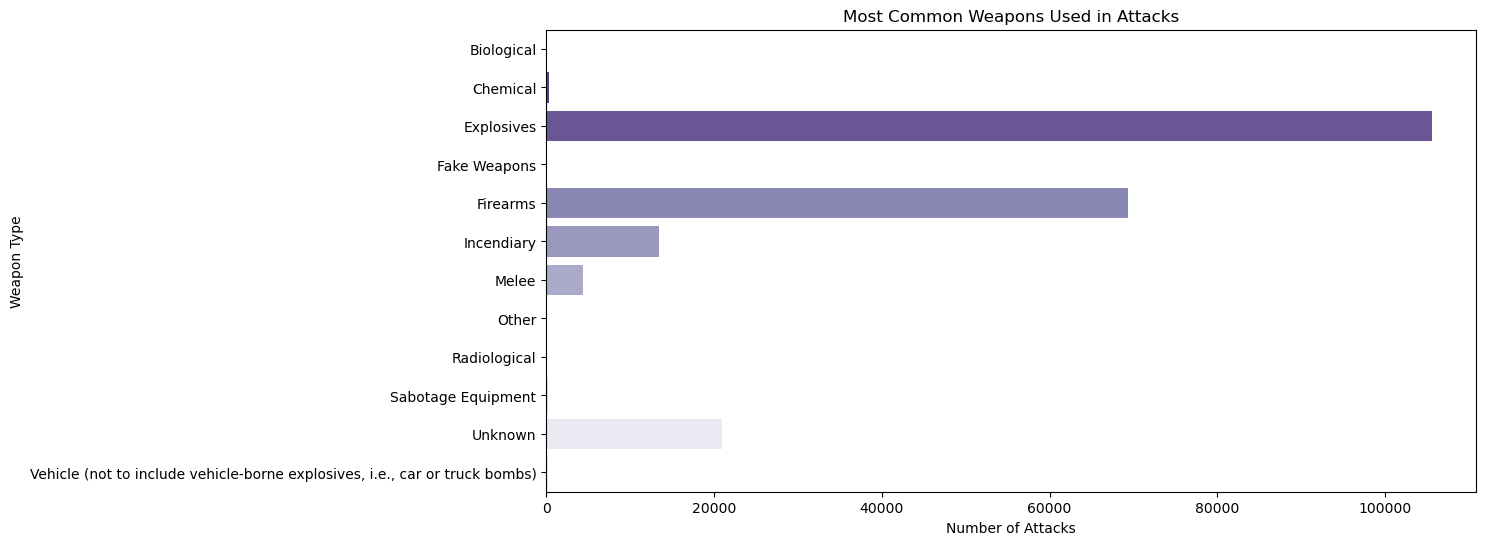

In [59]:
# Group by weapon type and count
weapons_used = ddf.groupby('weaptype1_txt').size().compute()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=weapons_used.values, y=weapons_used.index, palette="Purples_r")
plt.xlabel('Number of Attacks')
plt.ylabel('Weapon Type')
plt.title('Most Common Weapons Used in Attacks')
plt.show()